In [24]:
import os
import pickle as pkl
import csv
import math
import pandas as pd
import numpy as np


WDIRS = [    
    'results/seedrun_m1-2022-01-16/run_seed1394398/eval_more_0/',
    'results/seedrun_m1-2022-01-16/run_seed1394398/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_1/',
    'results/20220129-EVOL_b5-goodseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_1/',
    'results/seedrun_m1-2022-01-16/run_seed5397326/eval_more_0/',
    'results/seedrun_m1-2022-01-16/run_seed5397326/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_50/',
    'results/20220128-EVOL_b5-badseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_2/',
]

outdir = 'mapper-data/'

NAMES = ['INIT-S6', 'STDP-S6', 'EVOL-S6', 'INIT-S3', 'STDP-S3', 'EVOL-S3']

GET_ONLY = None
if GET_ONLY != None:
    WDIRS = WDIRS[GET_ONLY:GET_ONLY+1]
    NAMES = NAMES[GET_ONLY:GET_ONLY+1]

resolution = 49.8
offset = 49.8 * 3
N = 3000 # total_length // 5

for wdir, name in zip(WDIRS, NAMES):
    print(wdir)

    sim_path = os.path.join('../', wdir, 'sim.pkl')

    with open(sim_path, 'rb') as f:
        sim = pkl.load(f)

    total_length = math.ceil((sim['simData']['spkt'][-1] - offset) / resolution)
    num_gids = int(max(sim['simData']['spkid']) + 1)
    assert total_length >= N
    M = num_gids

    X = np.zeros((N, M), dtype=np.double)

    for spkt, spkid in zip(sim['simData']['spkt'], sim['simData']['spkid']):
        if spkt < offset:
            continue

        t = math.floor((spkt - offset) / resolution)
        if t >= N:
            continue
        X[t][int(spkid)] += 1.0
        
    np.save(outdir + name + '.npy', X)


results/seedrun_m1-2022-01-16/run_seed1394398/eval_more_0/
results/seedrun_m1-2022-01-16/run_seed1394398/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_1/
results/20220129-EVOL_b5-goodseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_1/
results/seedrun_m1-2022-01-16/run_seed5397326/eval_more_0/
results/seedrun_m1-2022-01-16/run_seed5397326/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_50/
results/20220128-EVOL_b5-badseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_2/


In [28]:
# Create task files
import json

# first K, middle, last K of an episode
EP_DUR = 10 # The K
for wdir, name in zip(WDIRS, NAMES):
    print(wdir)

    eps_path = os.path.join('../', wdir, 'ActionsPerEpisode.txt')
    episodes = []
    with open(eps_path) as f:
        for row in csv.reader(f, delimiter='\t'):
            episodes.append(int(float(row[1])))
            
    episodes[0] = episodes[0] - round(offset / resolution)
            
    histories = []
    for ep in episodes:
        if ep < EP_DUR * 2:
            n_firsts = math.floor(ep / 2)
            histories.extend((['start'] * n_firsts) + (['end'] * (ep - n_firsts)))
        else:
            histories.extend((['start'] * EP_DUR) + (['mid'] * (ep - 2 * EP_DUR)) + (['end'] * EP_DUR))
            
    histories = histories[:N]
    
    with open(outdir + name + '-task_EPDUR{}.csv'.format(EP_DUR), 'w') as out:
        out.write('task_name\n')
        for h in histories:
            out.write(h + '\n')
        
        
print('Rewards FILEs')
# Moves, rewards, angle direction
for wdir, name in zip(WDIRS, NAMES):
    print(wdir)

    rew_path = os.path.join('../', wdir, 'ActionsRewards.txt')
    rows = []
    with open(rew_path) as f:
        for i, row in enumerate(csv.reader(f, delimiter='\t')):
            if i < round(offset / resolution):
                continue
            obs = json.loads(row[3])
            rows.append({
                'move': 'left' if row[1] == '0.0' else 'right',
                'reward': 'reward' if float(row[2]) > 0 else 'punishment',
                'angle': '< 0.03' if abs(obs[2]) < 0.03 else ('< 0.1' if abs(obs[2]) < 0.1 else ' > 0.1')
            })
            
    for task in ['move', 'reward', 'angle']:
        with open(outdir + name + '-task_{}.csv'.format(task), 'w') as out:
            out.write('task_name\n')
            for i, row in enumerate(rows):
                if i >= N:
                    break
                out.write(row[task] + '\n')


results/seedrun_m1-2022-01-16/run_seed1394398/eval_more_0/
results/seedrun_m1-2022-01-16/run_seed1394398/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_1/
results/20220129-EVOL_b5-goodseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_1/
results/seedrun_m1-2022-01-16/run_seed5397326/eval_more_0/
results/seedrun_m1-2022-01-16/run_seed5397326/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_50/
results/20220128-EVOL_b5-badseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_2/
Rewards FILEs
results/seedrun_m1-2022-01-16/run_seed1394398/eval_more_0/
results/seedrun_m1-2022-01-16/run_seed1394398/continue_1/continue_1/continue_2/continue_2/continue_2/eval_more_1/
results/20220129-EVOL_b5-goodseed/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/continue_1/eval_more_1/
results/seedrun_m1-2022-01-16/run_seed53

In [15]:
len(histories)

10038

In [29]:
spikes = np.array(sim['simData']['spkt'])

In [30]:
max(spikes)

499998.4498002157

In [ ]:

[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.854675
[t-SNE] KL divergence after 1000 iterations: 2.159042

In [32]:
MOT_OUTS = []


for wdir in WDIRS:
    mot_path = os.path.join('../', wdir, 'MotorOutputs.txt')
    
    with open(mot_path) as f:
        mot_rews = [line for line in csv.reader(f, delimiter='\t')]

    y = np.zeros(N, dtype=np.short)

    for idx, row in enumerate(mot_rews):
        if float(row[0]) < offset:
            continue
        tstart = math.floor((float(row[0]) - offset) / resolution)

        if idx < len(mot_rews) - 1:
            tnext = math.floor((float(mot_rews[idx+1][0]) - offset) / resolution)
        else:
            tnext = N

        lmove, rmove = float(row[1]), float(row[2])
        move = 1 if lmove == rmove else (2 if lmove > rmove else 3)

        for t in range(tstart, tnext):
            if t >= N:
                continue
            y[t] = move
            
    MOT_OUTS.append(y)

STDP-S6


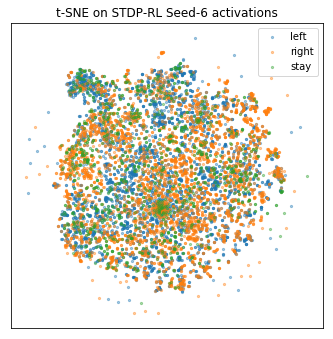

In [33]:
import matplotlib.pyplot as plt


for wdir, name, lens, y in zip(WDIRS, NAMES, LENSES, MOT_OUTS):
    print(name)

    S = 5
    plt.figure(figsize=(5,5))

    L = []

    for i in [2,3,1]:
        plt.scatter(lens[y == i][:,0], lens[y == i][:,1], 5, alpha=0.4)
        L.append(['stay', 'left', 'right'][i-1])

    plt.title('t-SNE on {} activations'.format(name.replace('-S', ' Seed-').replace('STDP', 'STDP-RL')))
    plt.tight_layout()

    plt.legend(L)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('tSNE-{}.png'.format(name.lower()), dpi=300)

## Below is deprecated

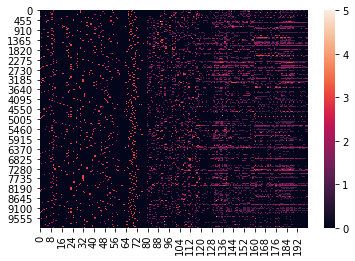

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

X = np.load('STDP-S6.npy')

sns.heatmap(X)
plt.show()

In [ ]:
import matplotlib
matplotlib.rcParams['font.family']


In [ ]:
ACTS_EPS = []

# EPS_INTERVALS = [
#     [0, 20],
#     [20, 30],
#     [30, 40],
#     [40, 60],
#     [60, 100],
#     [100, 150],
#     [150, 200],
#     [200, 300],
#     [300, 501]]

EPS_INTERVALS = [
    [0, 50],
    [50, 100],
    [100, 200],
    [200, 501]]


for wdir in WDIRS:
    acts_path = os.path.join(wdir, 'ActionsPerEpisode.txt')
    
    with open(acts_path) as f:
        acts = [int(float(line[1])) for line in csv.reader(f, delimiter='\t')]

    y = np.zeros(N, dtype=np.short)
    
    current_eps = 0
    for idx, eps in enumerate(acts):
        interval_idx = [i for i,(s,e) in enumerate(EPS_INTERVALS) if s <= eps and eps < e][0]
        
        tstart = current_eps
        tend = tstart + eps  + (-3 if idx == 0 else 0)

        for t in range(tstart, tnext):
            if t >= N:
                continue
            y[t] = interval_idx
            
        current_eps = tend
            
    ACTS_EPS.append(y)

In [ ]:
for wdir, name, lens, y in zip(WDIRS, NAMES, LENSES, ACTS_EPS):
    print(name)

    plt.figure(figsize=(10,10))

    L = []

    for i,(s,e) in enumerate(EPS_INTERVALS):
        plt.scatter(lens[y == i][:,0], lens[y == i][:,1], 5, alpha=0.7)
        L.append('Acts per Eps in [{},{})'.format(s,e))

    plt.title('t-SNE on {} activations'.format(name))
    plt.tight_layout()

    plt.legend(L)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('tSNE_actseps-{}.png'.format(name.lower()), dpi=300)

In [ ]:
import matplotlib.pyplot as plt

d = np.sum((lens[1:] - lens[:-1]) ** 2, axis=1)

plt.hist(d)

In [ ]:
graph = mapper.map(lens, X, cover=Cover(10, 0.8), clusterer=DBSCAN(eps=10.0))

In [ ]:
from dyneusr import DyNeuGraph

# Visualize the shape graph using DyNeuSR's DyNeuGraph                          
dG = DyNeuGraph(G=graph, y=y)
dG.visualize('dyneusr_stdp_p50.html')


In [ ]:
from dyneusr.tools import visualize_mapper_stages

fig, axes = visualize_mapper_stages(
    X, y=y, lens=lens, graph=graph, cover=mapper.cover,
    node_size=20, edge_size=0.5, edge_color='gray',
    layout="kamada_kawai",  figsize=(16, 4)
    )

plt.savefig('tSNE-stdp.png', dpi=300)
plt.show()

In [ ]:
lens[y == 1][:,0]